In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

tf.set_random_seed(777)

1.12.0


In [2]:
learning_rate = 0.0002
training_epochs = 100
batch_size = 100
noise_dim = 128

In [3]:
#mnist = keras.datasets.mnist
#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist = keras.datasets.fashion_mnist
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
(train_images, train_labels), (_, _) = mnist.load_data()

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
    buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()

In [6]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
images, labels = iterator.get_next()

In [7]:
train_init = iterator.make_initializer(train_dataset)

In [8]:
vec_images = tf.reshape(images, [-1, 28, 28, 1])
vec_images = tf.cast(vec_images, tf.float32) / 255.
onehot_labels = tf.one_hot(labels, 10)

In [9]:
Z = tf.placeholder(tf.float32, [None, noise_dim])

In [10]:
def generator(noise):
    with tf.variable_scope('generator') as scope:
        gen1 = tf.layers.dense(inputs=noise,
                               units=1024,
                               activation=tf.nn.leaky_relu,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen1)
        gen2 = tf.layers.dense(inputs=gen1,
                               units=7*7*64,
                               activation=tf.nn.leaky_relu,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen2)
        gen2 = tf.reshape(gen2, [-1, 7, 7, 64])
        print(gen2)
        gen3 = tf.layers.conv2d_transpose(inputs=gen2,
                                          filters=64,
                                          kernel_size=[5,5],
                                          strides=(2,2),
                                          padding='same',
                                          activation=tf.nn.leaky_relu,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen3)
        gen4 = tf.layers.conv2d_transpose(inputs=gen3,
                                          filters=1,
                                          kernel_size=[5,5],
                                          strides=(2,2),
                                          padding='same',
                                          activation=tf.nn.sigmoid,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen4)
        return gen4

In [11]:
def discriminator(image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        dis1 = tf.layers.conv2d(inputs=image,
                                filters=32,
                                kernel_size=[5,5],
                                strides=(2,2),
                                padding='same',
                                activation=tf.nn.leaky_relu,
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis1)
        dis2 = tf.layers.conv2d(inputs=dis1,
                                filters=64,
                                kernel_size=[5,5],
                                strides=(2,2),
                                padding='same',
                                activation=tf.nn.leaky_relu,
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis2)
        dis2 = tf.layers.flatten(dis2)
        print(dis2)
        dis3 = tf.layers.dense(inputs=dis2,
                               units=256,
                               activation=tf.nn.leaky_relu,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis3)
        dis4 = tf.layers.dense(inputs=dis3,
                               units=1,                               
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis4)
        return dis4

In [12]:
def get_noise(batch_size, noise_dim):
    return np.random.uniform(-1., 1., size=[batch_size, noise_dim])

In [13]:
G = generator(Z)

Tensor("generator/dense/LeakyRelu:0", shape=(?, 1024), dtype=float32)
Tensor("generator/dense_1/LeakyRelu:0", shape=(?, 3136), dtype=float32)
Tensor("generator/Reshape:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("generator/conv2d_transpose/LeakyRelu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("generator/conv2d_transpose_1/Sigmoid:0", shape=(?, 28, 28, 1), dtype=float32)


In [14]:
D_real = discriminator(vec_images)

Tensor("discriminator/conv2d/LeakyRelu:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("discriminator/conv2d_1/LeakyRelu:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("discriminator/flatten/Reshape:0", shape=(?, 3136), dtype=float32)
Tensor("discriminator/dense/LeakyRelu:0", shape=(?, 256), dtype=float32)
Tensor("discriminator/dense_1/BiasAdd:0", shape=(?, 1), dtype=float32)


In [15]:
D_fake = discriminator(G, True)

Tensor("discriminator_1/conv2d/LeakyRelu:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("discriminator_1/conv2d_1/LeakyRelu:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("discriminator_1/flatten/Reshape:0", shape=(?, 3136), dtype=float32)
Tensor("discriminator_1/dense/LeakyRelu:0", shape=(?, 256), dtype=float32)
Tensor("discriminator_1/dense_1/BiasAdd:0", shape=(?, 1), dtype=float32)


In [16]:
loss_D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=D_real, labels=tf.ones_like(D_real)))
loss_D_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=D_fake, labels=tf.zeros_like(D_fake)))

In [17]:
loss_D = loss_D_real + loss_D_fake

In [18]:
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_fake, labels=tf.ones_like(D_fake)))

In [19]:
vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

In [20]:
train_D = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_D, var_list=vars_D)
train_G = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_G, var_list=vars_G)

In [21]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(tf.global_variables_initializer())

Training Start
[[ 9.28801324e-02 -6.53552217e-02  8.21020641e-01 ...  7.97396093e-01
  -5.01047471e-01 -8.62740687e-01]
 [-9.75998463e-02  5.27171336e-01 -3.67805827e-01 ... -1.49408378e-01
   6.86809914e-01 -8.63617183e-01]
 [ 1.30947116e-01  5.88525207e-02 -1.16630016e-01 ...  3.39729537e-01
  -8.99327691e-01  4.64563023e-02]
 ...
 [-7.55655032e-01 -4.69636486e-01  6.97400478e-01 ...  5.44541131e-01
   1.88224590e-01 -3.91906430e-01]
 [-7.01444720e-01 -8.47383045e-01  7.23593492e-01 ...  1.19195781e-01
  -3.75305951e-01  2.89949066e-01]
 [-4.15618113e-01  5.99899167e-05  6.97506995e-01 ... -6.50564493e-02
   8.89760902e-01  7.99040874e-02]]


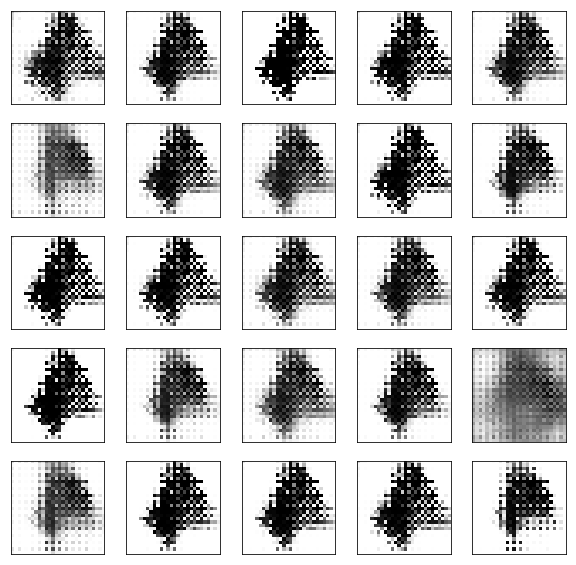

Epoch: 5 loss_D = 0.66209614 loss_G = 2.67023134
[[-0.01403621 -0.01622921  0.06725003 ...  0.43228454 -0.89555911
   0.16127106]
 [ 0.06521408  0.297727    0.78232386 ...  0.45333107 -0.13113091
  -0.5691564 ]
 [ 0.9070768   0.10268119  0.98046634 ...  0.85226685  0.63066779
  -0.40486747]
 ...
 [ 0.39371848 -0.43337281  0.38397257 ... -0.26153772  0.19287162
   0.36199767]
 [ 0.99423963 -0.92260773 -0.65561469 ...  0.53561548 -0.83463906
   0.8697183 ]
 [-0.88181505 -0.44562687  0.83148826 ...  0.90230014  0.6559809
   0.33334192]]


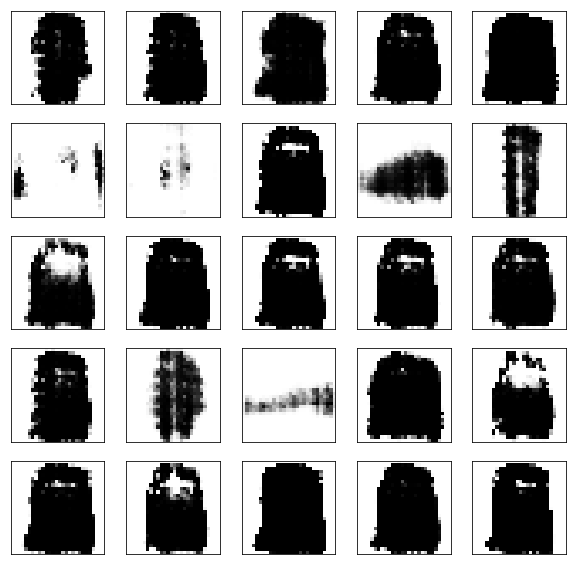

Epoch: 10 loss_D = 0.94949965 loss_G = 1.80068211
[[ 0.10588009  0.27163453 -0.50331672 ... -0.80108704 -0.00955038
   0.98708417]
 [-0.59795658 -0.11401269 -0.45958748 ...  0.70618758 -0.79647958
   0.96750095]
 [-0.39161052  0.77615431  0.80684209 ... -0.36482851 -0.81898738
  -0.83079359]
 ...
 [ 0.89806904 -0.94824763  0.72446801 ... -0.49290233  0.21175999
  -0.64220137]
 [-0.00996275 -0.62298027  0.70409282 ...  0.04101239 -0.07487598
  -0.36411583]
 [-0.56083006  0.4247907   0.83526152 ...  0.76835729 -0.56443856
   0.48076989]]


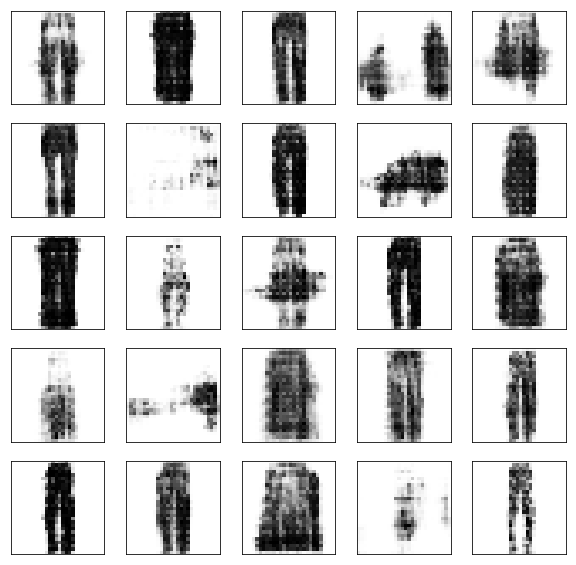

Epoch: 15 loss_D = 1.30013999 loss_G = 0.89577707
[[ 0.37876066  0.27520972 -0.59462228 ... -0.39018289 -0.8392385
   0.20715452]
 [-0.95128565  0.55492001 -0.35989117 ...  0.19308674  0.80426828
   0.04761862]
 [-0.14829245 -0.91440842  0.13296848 ...  0.73573469  0.99446994
  -0.96688263]
 ...
 [ 0.6507111   0.12123248  0.26013026 ... -0.42544141 -0.67147126
  -0.77735715]
 [ 0.90306455 -0.05615423  0.01878939 ... -0.20052223  0.34983678
   0.19087419]
 [-0.32401413  0.43232327  0.21913981 ... -0.35223745  0.94574927
   0.05149297]]


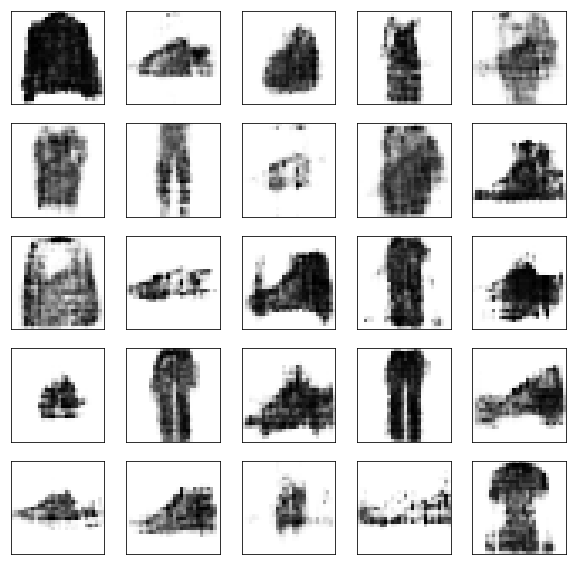

Epoch: 20 loss_D = 1.32724197 loss_G = 0.86641778
[[ 0.2245055   0.91583163  0.38769941 ...  0.45165944 -0.8862874
  -0.46158982]
 [-0.44562257  0.87108634  0.99427901 ... -0.97566424 -0.01044133
   0.37740462]
 [ 0.56804189  0.25819162 -0.99704798 ... -0.50759209 -0.39043868
   0.62306652]
 ...
 [-0.54740514  0.12967241  0.23569709 ... -0.36149804 -0.85774603
  -0.72887754]
 [-0.28761053 -0.62403731 -0.87885661 ... -0.32424795 -0.01278371
  -0.82207694]
 [ 0.1419815  -0.14996153  0.23139842 ... -0.04574648 -0.20247233
   0.98135154]]


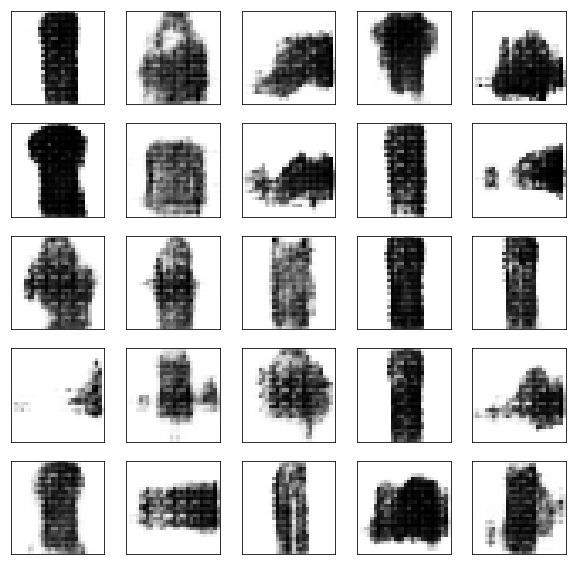

Epoch: 25 loss_D = 1.30291955 loss_G = 0.93094062
[[-0.25101253 -0.23029312 -0.01865974 ...  0.19591459  0.77878401
   0.14856048]
 [-0.48552272 -0.47710313 -0.66423379 ...  0.93645207 -0.63063203
   0.54189718]
 [-0.65019117 -0.62020076 -0.04689335 ...  0.31509581 -0.26365872
   0.55556329]
 ...
 [-0.49897264 -0.18742672  0.04922215 ...  0.61153669  0.72244573
   0.56954344]
 [-0.32107211 -0.19961251  0.39228588 ...  0.26221417 -0.71321347
  -0.67194309]
 [-0.51717993  0.47756844 -0.94281192 ...  0.45208671 -0.83773481
  -0.11634634]]


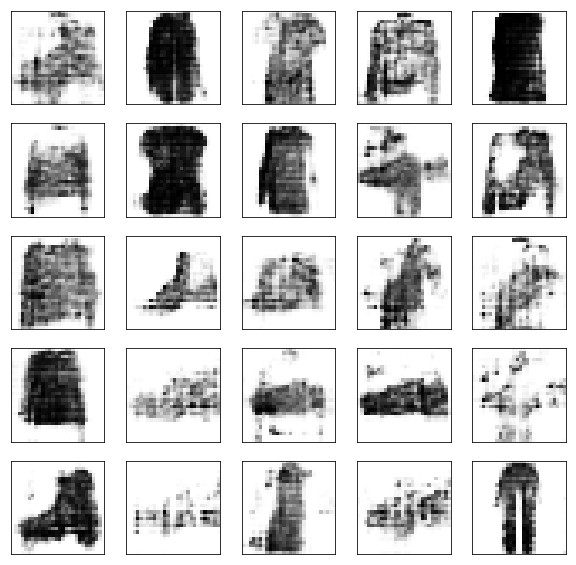

Epoch: 30 loss_D = 1.33816898 loss_G = 0.80569443
[[-0.51917364 -0.79776893 -0.81584449 ...  0.30704901  0.95090763
   0.64649976]
 [ 0.0869853  -0.39357195 -0.62344718 ... -0.95814377 -0.12183998
   0.56192257]
 [ 0.32248484  0.02407287 -0.71473303 ...  0.72150272 -0.363587
  -0.96171928]
 ...
 [ 0.2056201   0.36972114 -0.33346106 ...  0.21998875 -0.0453597
  -0.21940761]
 [ 0.45260968 -0.25021913  0.41217244 ... -0.39489413 -0.29568173
   0.61272618]
 [-0.37915655 -0.37364733 -0.75005602 ... -0.59572888  0.89518765
  -0.67908484]]


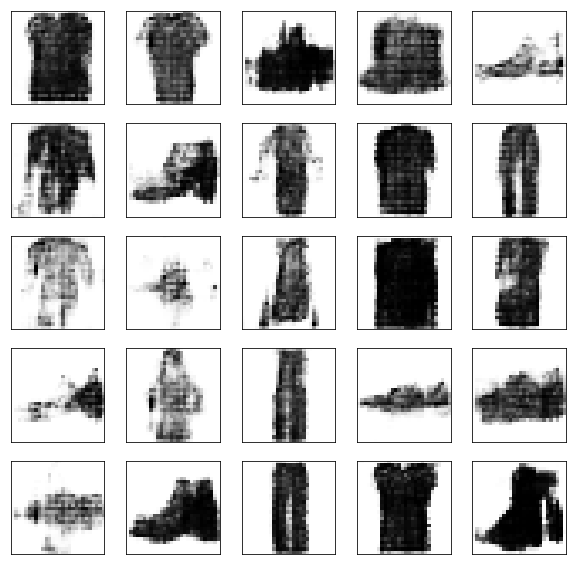

Epoch: 35 loss_D = 1.34106450 loss_G = 0.83458827
[[ 0.24927326  0.88197508  0.39206286 ... -0.35790549  0.99830016
  -0.07655763]
 [-0.26992205  0.88233629 -0.31762228 ...  0.31584045  0.34568954
  -0.00677521]
 [ 0.7134655  -0.60375148 -0.80764707 ...  0.5151428   0.23258925
   0.70458486]
 ...
 [-0.1683061  -0.82756707  0.9789878  ... -0.85941745  0.32829091
   0.6621603 ]
 [ 0.97215796 -0.66302874 -0.45307264 ...  0.07361166 -0.67846146
   0.02949513]
 [ 0.12405853 -0.22875589 -0.86565658 ... -0.42539499  0.4876722
  -0.95092396]]


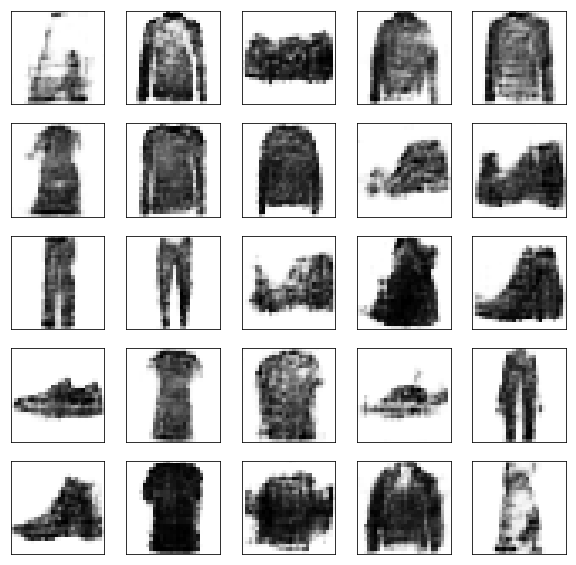

Epoch: 40 loss_D = 1.36277891 loss_G = 0.76029612
[[ 0.79808471 -0.68928403  0.45340861 ...  0.42806994  0.25763746
  -0.06324897]
 [ 0.92302308  0.39218308 -0.21130939 ...  0.13231898 -0.87548873
   0.67446196]
 [ 0.81091991  0.33435285  0.13511354 ...  0.86064228  0.43669864
   0.95258204]
 ...
 [ 0.61116159  0.13563801  0.3510182  ...  0.54155064 -0.21041303
   0.03886997]
 [-0.26831114  0.28110293 -0.95981439 ... -0.21290373 -0.50439317
  -0.44887187]
 [ 0.14799857 -0.53812902  0.43589774 ... -0.56468688 -0.1010084
  -0.9052965 ]]


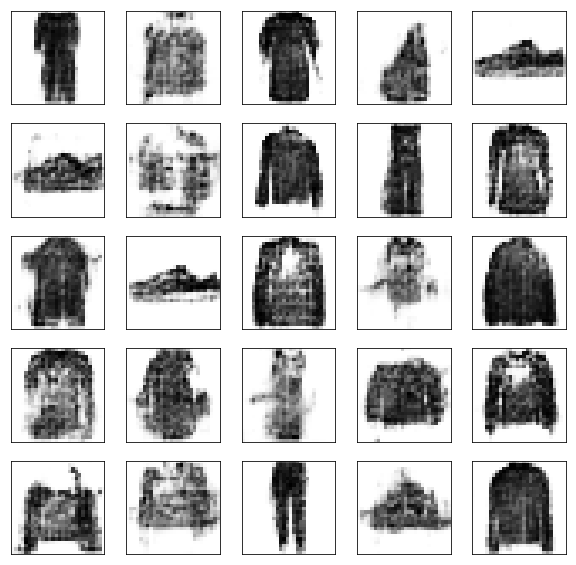

Epoch: 45 loss_D = 1.37139652 loss_G = 0.73642170
[[-0.24598776  0.48554268 -0.50583025 ... -0.09836113 -0.66968584
  -0.2302747 ]
 [-0.73149272 -0.33062535  0.02677499 ... -0.39465204 -0.39859319
   0.81365311]
 [-0.28621135  0.8531316   0.68483898 ...  0.16748577 -0.23075689
   0.24495236]
 ...
 [-0.8167998  -0.3948016   0.50323396 ...  0.44786407  0.22734419
  -0.93375332]
 [-0.68203849 -0.86627386 -0.55494755 ...  0.99657767 -0.81630529
   0.07217912]
 [-0.97828925  0.03923057 -0.74821057 ...  0.99984407  0.88091676
   0.70814508]]


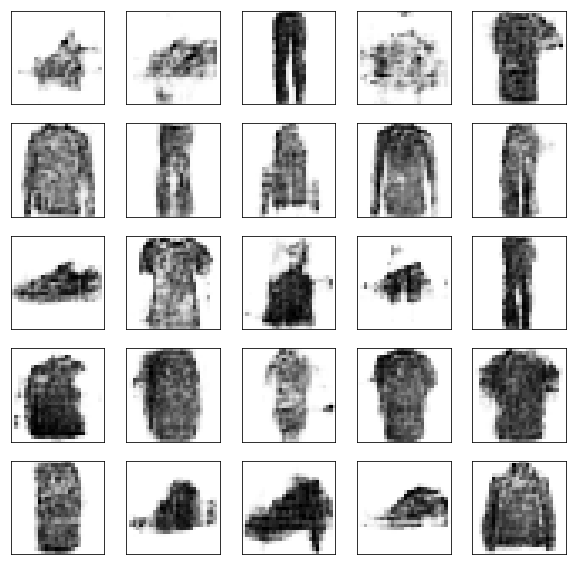

Epoch: 50 loss_D = 1.37107775 loss_G = 0.75186163
[[-0.7000227   0.47398318  0.76214546 ...  0.75839318 -0.42724275
   0.43599752]
 [-0.82234498 -0.07524178  0.04783476 ...  0.81654057  0.53216442
  -0.16148269]
 [ 0.87693735  0.01168275  0.73224885 ... -0.16801729 -0.17753394
  -0.90130277]
 ...
 [ 0.27651838 -0.40671845  0.03129045 ...  0.44784072 -0.34144141
   0.11163593]
 [ 0.55913966 -0.68148042  0.89399869 ... -0.86933953 -0.22074884
  -0.62109212]
 [-0.33090772  0.15159704  0.56893822 ... -0.28813968  0.12373888
  -0.9024392 ]]


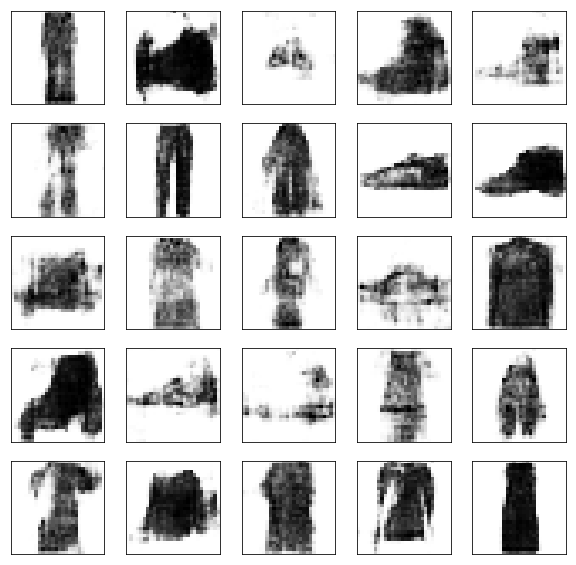

Epoch: 55 loss_D = 1.36659417 loss_G = 0.78156841
[[-0.52507922  0.07130382 -0.74335928 ... -0.86785954  0.52132548
   0.60512354]
 [-0.15272903 -0.28520871  0.6607553  ... -0.12204661  0.55691261
   0.95437519]
 [ 0.24538529  0.81498721 -0.18956302 ...  0.09341375 -0.60658865
  -0.1487174 ]
 ...
 [ 0.84117452 -0.07640861  0.8467131  ...  0.8692054   0.11549992
   0.17825981]
 [-0.06418705  0.78511416  0.8332433  ... -0.69787502  0.15835603
   0.00655138]
 [ 0.34444709  0.8811554   0.79685519 ...  0.55299476  0.53998898
  -0.47068909]]


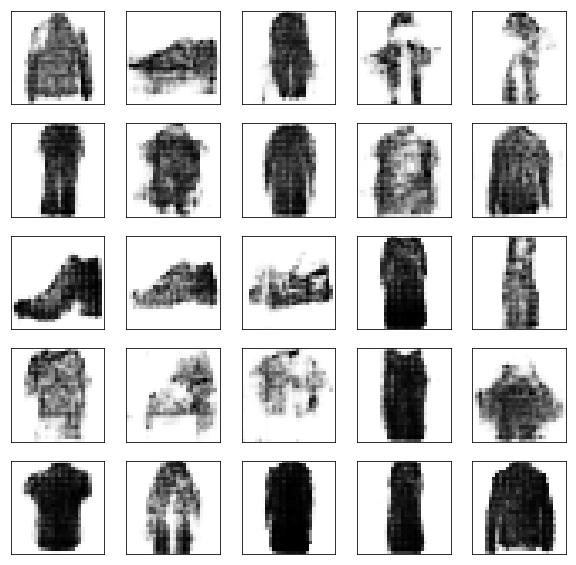

Epoch: 60 loss_D = 1.35387606 loss_G = 0.78591958
[[ 0.55178495  0.96381593  0.20150019 ...  0.90914117  0.0302853
  -0.54601651]
 [ 0.49036081  0.67312162  0.45578847 ...  0.1897804  -0.87676272
  -0.79093416]
 [ 0.26924537 -0.39763147  0.08633458 ... -0.61431744 -0.85074519
  -0.57716075]
 ...
 [ 0.03737035 -0.17016566 -0.2189959  ... -0.21781767 -0.52139918
   0.16201466]
 [ 0.14206627  0.5633971   0.76668542 ...  0.20834545  0.78074304
   0.17914659]
 [ 0.24541896 -0.81066775  0.54315865 ...  0.41849739  0.17186674
   0.77851038]]


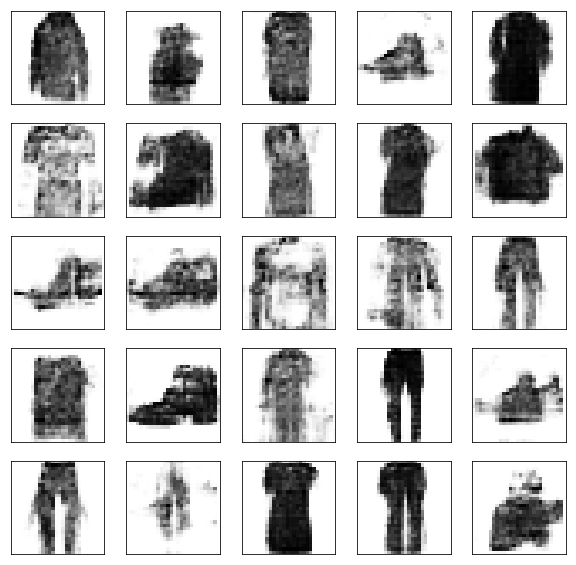

Epoch: 65 loss_D = 1.36633882 loss_G = 0.76757530
[[ 0.74579399  0.1837711  -0.38816503 ... -0.09602792  0.02875329
   0.62523972]
 [-0.72730328  0.05307535  0.04397484 ... -0.60474322 -0.8803977
   0.1879846 ]
 [ 0.27415552 -0.35900385 -0.21363258 ... -0.82386625  0.30085294
   0.61653141]
 ...
 [ 0.58944277 -0.60118806 -0.4406332  ... -0.23827769  0.53007079
   0.25092439]
 [ 0.43298818 -0.42332027  0.55571006 ...  0.78234281 -0.54583094
  -0.54571716]
 [ 0.00285545  0.19174515 -0.07285401 ... -0.46873224  0.91923686
   0.83822169]]


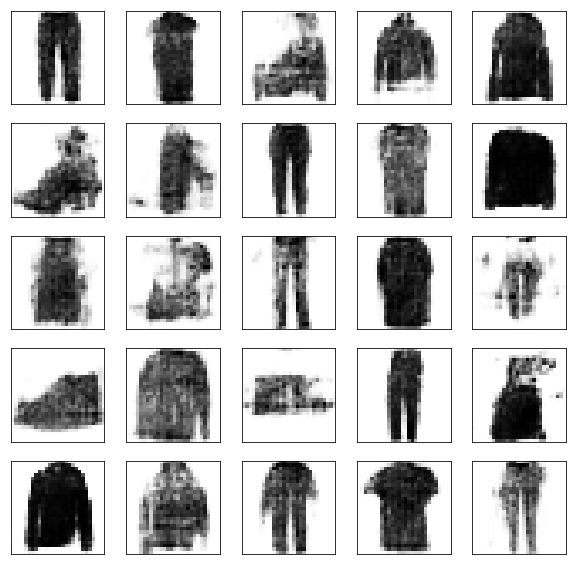

Epoch: 70 loss_D = 1.36521836 loss_G = 0.74495347
[[-0.96166964  0.06206453 -0.2843476  ... -0.14439417 -0.87338698
   0.18923832]
 [ 0.90546961  0.46232576  0.18085639 ... -0.64664616 -0.21682701
  -0.46498704]
 [ 0.47833537  0.85669482 -0.27546061 ... -0.7525136  -0.54869818
   0.0666787 ]
 ...
 [-0.60048719 -0.89709237 -0.44151246 ...  0.68757886  0.62031998
   0.97823648]
 [-0.52232938 -0.87453139 -0.07642171 ...  0.1964018   0.9691787
   0.00536953]
 [-0.10857702  0.22205964 -0.16250897 ... -0.32643142  0.0650666
   0.28690928]]


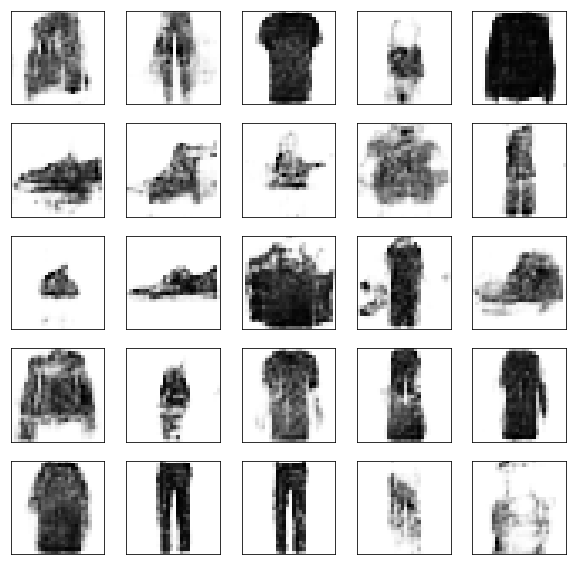

Epoch: 75 loss_D = 1.37388897 loss_G = 0.73689968
[[-0.16630029 -0.36093646  0.78224186 ... -0.46196723  0.53857561
   0.19850555]
 [ 0.92643379  0.74301821 -0.74452165 ... -0.07523048  0.63673038
   0.34397519]
 [ 0.87403525  0.94695831  0.04284309 ...  0.94110907 -0.01848894
   0.67569883]
 ...
 [ 0.37941475  0.19879752  0.03582888 ...  0.67147792 -0.79256677
   0.04125731]
 [ 0.07278849  0.677958    0.38048402 ...  0.70032875  0.85959444
   0.07489459]
 [-0.18833271  0.77071464  0.48758553 ... -0.81939672  0.88732562
  -0.46815765]]


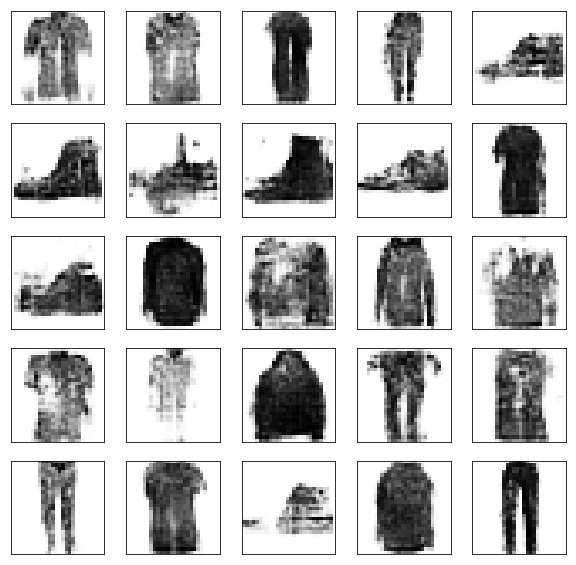

Epoch: 80 loss_D = 1.37621164 loss_G = 0.72866148
[[ 0.15580271 -0.3629743   0.73288149 ... -0.06849614  0.47619791
   0.94936207]
 [ 0.50491183  0.1492853  -0.94145272 ... -0.21057027 -0.01947972
  -0.621476  ]
 [-0.36527713 -0.36463605  0.71743737 ...  0.22272732 -0.54321867
  -0.70718463]
 ...
 [-0.37226496  0.01024278  0.78251707 ... -0.71528836  0.42810636
  -0.53183789]
 [ 0.27637589 -0.43612986 -0.13487161 ... -0.49064906 -0.36961621
  -0.05156665]
 [-0.89484081  0.2707708  -0.21881541 ...  0.05970095 -0.42266222
   0.97082146]]


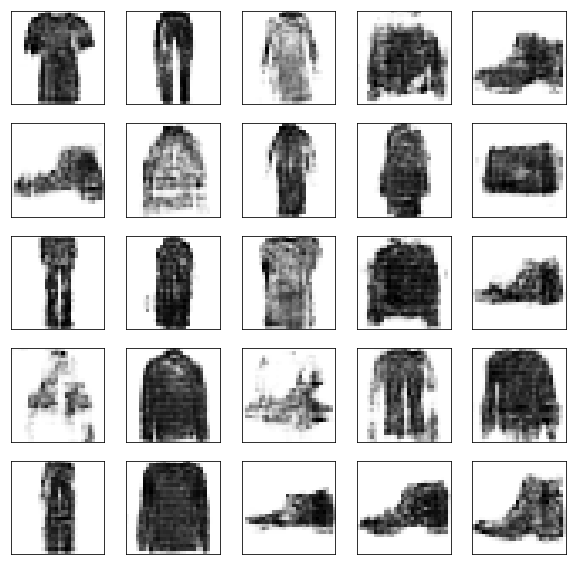

Epoch: 85 loss_D = 1.37577548 loss_G = 0.72636575
[[-0.43054904  0.25796355  0.30072144 ... -0.18821233  0.84091921
  -0.90367247]
 [-0.23297424 -0.72624547  0.92955648 ... -0.86823238 -0.37265284
  -0.48555407]
 [ 0.71917126  0.31592395  0.64262155 ... -0.05715716  0.98313565
  -0.48980123]
 ...
 [ 0.31427768  0.74001236 -0.39448725 ...  0.28901233  0.23889152
   0.05126019]
 [ 0.72823842 -0.07560324 -0.04135663 ... -0.99400827 -0.55915137
   0.16896004]
 [ 0.24740739  0.15183998 -0.68062027 ...  0.78469121  0.53443347
   0.67007747]]


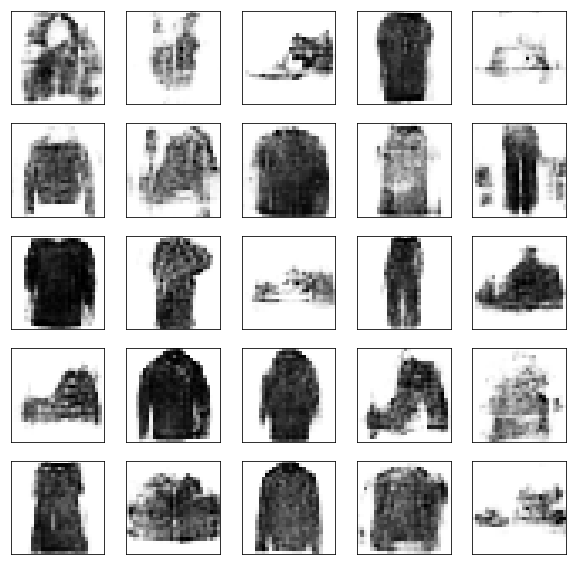

Epoch: 90 loss_D = 1.37666721 loss_G = 0.76194700
[[ 0.5440876   0.68426771 -0.78018726 ... -0.92074029  0.86525224
   0.97786059]
 [-0.86399771 -0.21252832  0.43706801 ...  0.61868741  0.56923627
  -0.69588085]
 [-0.17040057  0.36595432 -0.52553538 ... -0.07469363 -0.15691239
  -0.22818441]
 ...
 [ 0.97641548 -0.4533444   0.37019459 ...  0.39541785 -0.17790726
   0.17332309]
 [ 0.03822408 -0.66537872  0.31083238 ... -0.61477996 -0.54914022
  -0.22730179]
 [ 0.68781095 -0.83415976 -0.01411745 ... -0.55039734 -0.55145935
   0.0157761 ]]


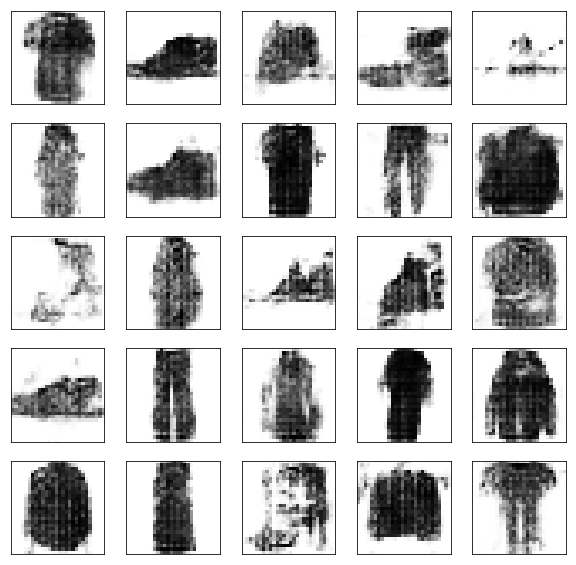

Epoch: 95 loss_D = 1.37682584 loss_G = 0.74237537
[[ 0.30701995  0.16347169 -0.90862102 ...  0.6681647   0.87871516
   0.59961538]
 [ 0.29179692  0.62169418  0.96256949 ...  0.37015596 -0.4887616
   0.25624412]
 [ 0.11521548 -0.57177863 -0.39684621 ... -0.78271244  0.59817764
   0.96684969]
 ...
 [ 0.82230425 -0.879907   -0.68237703 ...  0.34274239 -0.02205408
  -0.37709087]
 [-0.92697684 -0.89639726  0.4190814  ...  0.86947437 -0.33131676
   0.70527165]
 [-0.56978642 -0.31458926 -0.89906165 ...  0.25868004 -0.84560127
  -0.09522325]]


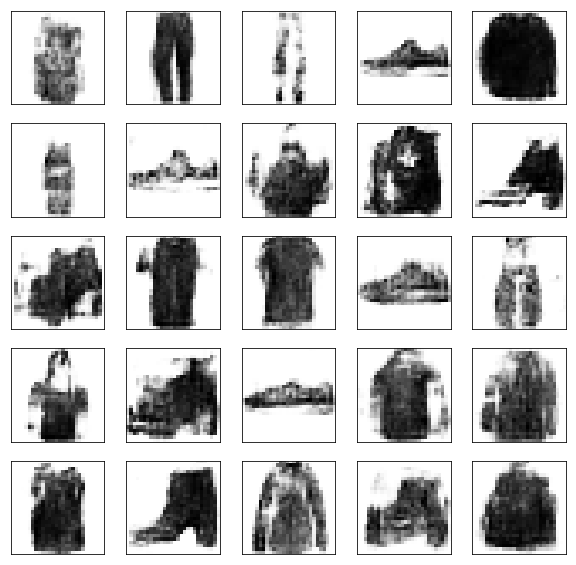

Epoch: 100 loss_D = 1.37262778 loss_G = 0.75467193
[[-0.49419318  0.23052068 -0.08259508 ...  0.49126319  0.31548604
  -0.45814347]
 [ 0.93074395  0.34178266 -0.48271983 ... -0.08528908 -0.82949162
   0.94345619]
 [ 0.97811849 -0.43101972  0.29319638 ... -0.2021724   0.3027968
   0.39529723]
 ...
 [ 0.79760721  0.44521975  0.4459982  ... -0.17869835 -0.37511357
   0.49724224]
 [-0.61285568 -0.9945011  -0.64765685 ...  0.397875    0.97128325
   0.59210887]
 [-0.23039241  0.09883036 -0.04127396 ...  0.36665567  0.06298591
  -0.56083617]]


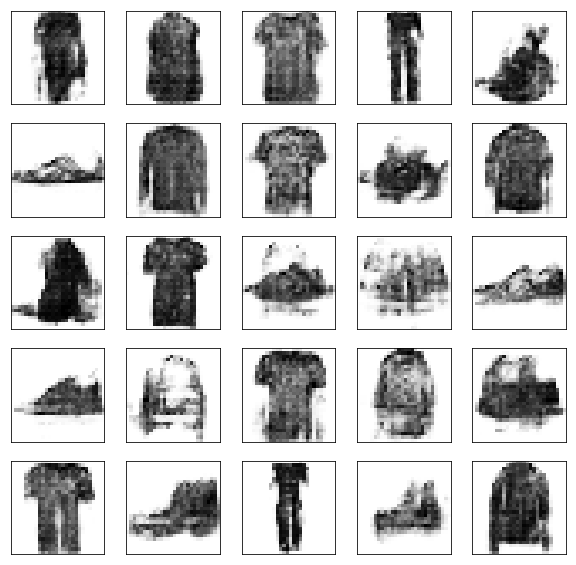

In [22]:
print('Training Start')
for epoch in range(training_epochs):
    avg_loss_D = 0.
    avg_loss_G = 0.
    total_batch = int(train_images.shape[0] / batch_size)    
    
    sess.run(train_init)
    noise = get_noise(batch_size, noise_dim)
    
    for i in range(total_batch):
        _, l_D = sess.run([train_D, loss_D], feed_dict={Z: noise})
        _, l_G = sess.run([train_G, loss_G], feed_dict={Z: noise})
        avg_loss_D += l_D / total_batch
        avg_loss_G += l_G / total_batch
    
    if (epoch+1) % 5 == 0:
        print('Epoch:', '{}'.format(epoch + 1),
              'loss_D =', '{:.8f}'.format(avg_loss_D),
              'loss_G =', '{:.8f}'.format(avg_loss_G))
    if epoch == 0 or (epoch+1) % 5 == 0:
        sample_size = 25
        noise = get_noise(sample_size, noise_dim)
        print(noise)
        samples = sess.run(G, feed_dict={Z: noise})
        #print(samples)
        
        plt.figure(figsize=(10,10))
        for i in range(sample_size):
            plt.subplot(5,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(samples[i,:,:,0], cmap=plt.cm.binary)
        plt.show()